# Color Evolution

This notebook uses a Gaussian regression to fit CSP light curves and model the evolution of observed color over time. Results are compared to the color evolution of various supernova models.

#### Table of Contents:

1. <a href='#color_evolution'>Model Color Evolution</a>:  Compare the CMFGEN modeled colors against Salt2.4
1. <a href='#compare_colors'>Comparing Gaussian and Modeled Colors</a>: Compare the regressed color evolution against each model
1. <a href='#chi_dist'>$\chi^2$ Distribution</a>: Examine distribution of chi-squared results
1. <a href='#delta_color'>$\Delta c_{15}$ Distribution</a>: Examine the change in color over 15 days ($\Delta C_{15}$)


In [1]:
import itertools
import sys
from copy import deepcopy
from pathlib import Path

import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sndata.csp import DR3

sys.path.insert(0, '../')
from analysis import models
from analysis import lc_colors
from analysis import regression
from analysis import utils
from analysis.exceptions import NoCSPData


## Model Color Evolution <a id='color_evolution'></a>

We begin by defining each model in memory. This includes four CMFGEN models in addition to the salt2.4 and Hsiao models.We also add a custom extinction component to each model using the Fitzpatrick 99 extinction law.

In [2]:
# Register models and data with sncosmo
models.register_sources(force=True)

dr3 = DR3()
dr3.download_module_data()
dr3.register_filters(force=True)

# Load various SN models
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))
hsiao = sncosmo.Model(sncosmo.get_source('hsiao'))
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))

# Add an extinction component to each model
# The extinction component is zero until changed
model_list = m102, m104, m14, m17, hsiao, salt2
for model in model_list:
    model.add_effect(sncosmo.F99Dust(), 'ext', 'rest')


To develop intuition, we compare the color color evolution of each model. We recognize that the color evolution of Salt2 is dependent on the model parameters. However, we only concern ourselves with a fiducial model having the default parameters.


In [3]:
def legend_without_duplicate_labels(ax):
    """Add a legend to a figure axis that only has unique labels
    
    Args:
        ax (axis): A matplotlib axis
    """

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


def subplot_model_colors(model, band_combos, axes, **kwargs):
    """Plot model colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        model                  (Model): Model to calculate color with
        band_combos (list[tuple[str]]): Band combos to calculate color for
        axes                   (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """

    axis_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    if len(axis_list) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    time = np.arange(model.mintime(), model.maxtime())
    t0 = model.source.peakphase('csp_dr3_B')
    for (band1, band2), axis in zip(band_combos, axis_list):
        try:
            c = model.color(band1, band2, 'ab', time)
            
        except ValueError as e:
            print(f'{model.source.name} {model.source.version}: {e}')
            pass

        else:
            label = f'{model.source.name} {model.source.version}'
            axis.plot(time - t0, c, label=label, **kwargs)
            
            y_label = f'{band1.split("_")[-1]} - {band2.split("_")[-1]}'
            axis.set_ylabel(y_label)
            axis.set_xlabel('Phase')
            axis.xaxis.set_minor_locator(MultipleLocator(10))
            legend_without_duplicate_labels(axis)


def plot_model_colors(models, colors):
    """Plot model colors for a given collection of models and bandpasses
    
    Args:
        models (list[Model]): Models to calculate color with
        bands   (tuple[str]): Band combinations to plot color for
    
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    columns = 3
    rows = int(np.ceil(len(colors) / columns))
    fig_shape = (rows, columns)
    fig_size = (6 * rows, 3 * columns)
    
    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for model in models:
        subplot_model_colors(model, colors, axes)
        
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    plt.tight_layout()

    return fig, axes


/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:1528: RuntimeWarning: invalid value encountered in subtract
  self.bandmag(band2, magsys, time))
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:1528: RuntimeWarning: invalid value encountered in subtract
  self.bandmag(band2, magsys, time))
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186

salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2000, .., 9200]


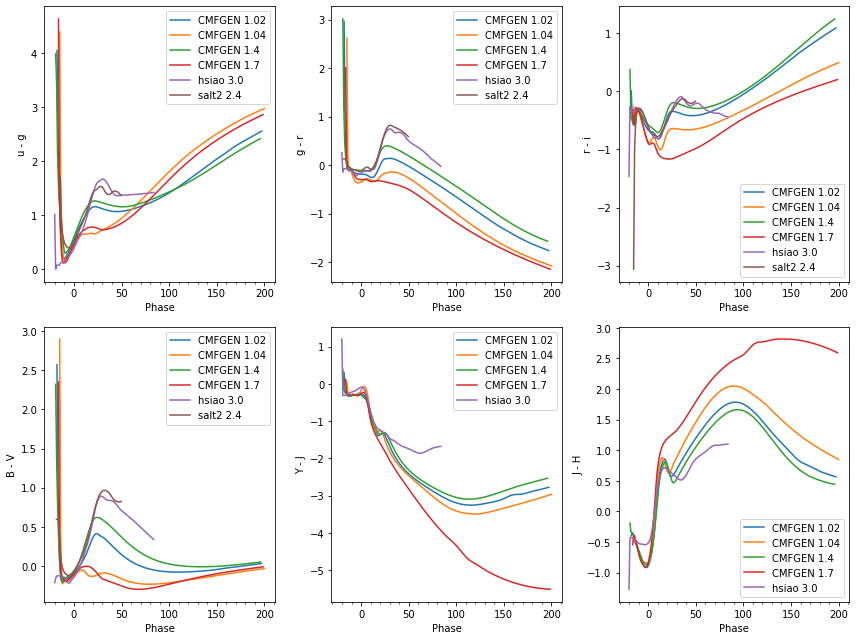

In [4]:
# Protect against chages that may 
# propagate from other places in the notebook
for model in model_list: 
    model.set(extebv=0)

colors = [
    ('csp_dr3_u', 'csp_dr3_g'),
    ('csp_dr3_g', 'csp_dr3_r'),
    ('csp_dr3_r', 'csp_dr3_i'),
    ('csp_dr3_B', 'csp_dr3_V'),
    ('csp_dr3_Y', 'csp_dr3_J'),
    ('csp_dr3_J', 'csp_dr3_H')
]

fig, axes = plot_model_colors(model_list, colors)


## Comparing Gaussian and Modeled Colors <a id='compare_colors'></a>

Next we use a Gaussian regression to estimate the observed color evolution and compare it against the CMFGEN models. To compare each model against the observed light curves, the data and models need to share a common time axis. We accomplish this by using the CSP published `t0` value to shift the observed time axis so that `t=0` corresponds with the time of peak flux in the B-band. 

To account for each observed light-curve being subject to different levels of extinction, we use set the models to the median extinction of the observations.


In [14]:
def subplot_regression_color(data, band_combos, axes, **kwargs):
    """Plot regressed colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        gp            (GP): A fitted gaussian process
        t0         (float): Time of B max for the fitted target
        band_combos (list): List of tuples with two bandpass names
        axes       (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """

    if len(axes.flatten()) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    t0 = utils.get_csp_t0(data.meta['obj_id'])
    gp = lc_colors.fit_gaussian_process(data)
    for (band1, band2), axis in zip(band_combos, axes.flatten()):
        try:
            tstart, tend = lc_colors.get_observed_color_times(data, band1, band2)
        
        except ValueError:
            continue
        
        else:
            time = np.arange(tstart, tend)
            color, color_err = regression.predict_color(gp, time, band1, band2)
            if any(color > 4):
                print(data.meta['obj_id'])
            axis.plot(time, color, label='Regression', **kwargs)
            legend_without_duplicate_labels(axis)


../analysis/regression/_lc_regression.py:107: UserWarning: GP fit failed! Using guessed GP parameters. 
  warn("GP fit failed! Using guessed GP parameters. ")
../analysis/regression/_lc_prediction.py:83: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * (np.log10(band1_pred) - np.log10(band2_pred)) + zp1 - zp2
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


2008bc


../analysis/regression/_lc_prediction.py:83: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * (np.log10(band1_pred) - np.log10(band2_pred)) + zp1 - zp2
/home/djperrefort/anaconda3/envs/cmfgen/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


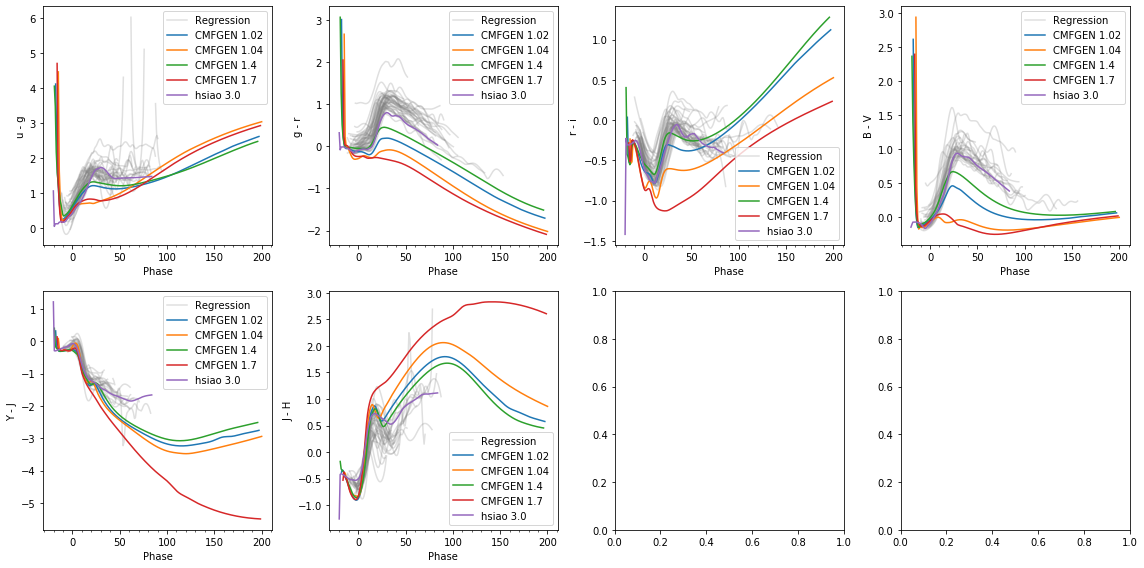

In [15]:
fig_shape = (2, 4)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)

table_2 = dr3.load_table(2)
normal_sne = table_2[table_2['Subtype1'] == 'normal']['SN']

extinction = []
for obj_id in normal_sne:
    data = dr3.get_data_for_id(obj_id)
    try:
        data['time'] -= utils.get_csp_t0(obj_id)
        extinction.append(utils.get_csp_ebv(obj_id))
        subplot_regression_color(data, colors, axes, color='grey', alpha=.25)
        
    except NoCSPData:
        pass

# Skip the salt2 model
for model in model_list[:-1]: 
    model.set(extebv=np.median(extinction))
    subplot_model_colors(model, colors, axes)

# axes[-1][-1].legend()
plt.tight_layout()


## $\chi^2$ Distribution <a id='chi_dist'></a>

Since we are using a Gaussian regression to interpolate the measured data, we can calculate the chi-squared by sampling the difference between the data and the models over some phase range. It is important to note that the chi-squared value is dependant on the observed phase range. Thus, we calculate three sets of chi-squared values: Once over the entire, color specific observed phase range, once from -10 to 20 days, and once over -15 to 25 days.

In [9]:
def iter_plot_data(chisq_df):
    """Iterate over chi-squares for source / version combinations
    
    Args:
        chisq_df (DataFrame): DataFrame of chi-squared values
        
    Yields:
        The color name as a string
        The lagend labels as a list of strings
        An array of chi-squared values
    """
    
    color_cols = [c for c in chisq_df.columns if not c.endswith('dof')]
    for col_name in color_cols:
        chisq_data = chisq_df[[col_name, col_name + '_dof']].dropna()
        chi_dof = (chisq_data[col_name] / chisq_data[col_name + '_dof'])
        out_data = chi_dof.groupby(['source', 'version'])
        if out_data:
            labels, data = np.array(out_data).T
            formatted_labels = [' '.join(l) for l in labels]
            formatted_color_name = col_name.replace('_', ' - ')
            yield formatted_color_name, formatted_labels, data
    

def plot_chisq_hist(chisq, err_scale, **kwargs):
    """Plot a histogram of chi-squared values
    
    Args:
        chisq     (Table): An astropy table generated by the lc_colors module
        err_scale (float): Scale the error values used in the chi-squared calculation
        Any other arguments for axis.hist
    """
    
    chisq_df = chisq.to_pandas()
    chisq_df.set_index(['obj_id', 'source', 'version'], inplace=True)
    plot_data = list(iter_plot_data(chisq_df))
    
    columns = 3
    rows = int(np.ceil(len(plot_data) / 3))
    fig_shape = (rows, columns)
    fig_size = (4 * columns, 3 * rows)
    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)

    iter_axes = iter(axes.flatten())
    for (name, labels, axis_data), axis in zip(plot_data, iter_axes):
        axis.hist(axis_data / (err_scale ** 2), label=labels, **kwargs)
        axis.set_title(f'{name}  ({len(axis_data[0])} Targets)')
    
    axis.legend()
    for axis in iter_axes:
        axis.remove()

    return fig, axes


In [10]:
results_dir = Path('../results/')
no_limit_chi = Table.read(results_dir / 'color_chisq/no_limit.ecsv')
small_range_chi = Table.read(results_dir / 'color_chisq/n5.0_20.0.ecsv')
large_range_chi = Table.read(results_dir / 'color_chisq/5.0_50.0.ecsv')

no_limit_chi[:5]


obj_id,source,version,u_g,u_g_dof,g_r,g_r_dof,r_i,r_i_dof,B_i,B_i_dof,B_V,B_V_dof,B_V0,B_V0_dof,B_V1,B_V1_dof,Y_J,Y_J_dof,Y_Jdw,Y_Jdw_dof,Ydw_J,Ydw_J_dof,Ydw_Jdw,Ydw_Jdw_dof,J_H,J_H_dof,J_Hdw,J_Hdw_dof,Jdw_H,Jdw_H_dof,Jdw_Hdw,Jdw_Hdw_dof
str6,str6,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2004ef,CMFGEN,1.04,--,56.0,--,75.0,--,75.0,--,67.0,--,--,--,67.0,--,--,--,--,--,--,--,13.0,--,--,--,13.0,--,--,--,--,--,--
2004eo,CMFGEN,1.04,--,57.0,--,77.0,--,77.0,--,77.0,--,--,--,77.0,--,--,--,--,--,--,--,38.0,--,--,--,38.0,--,--,--,--,--,--
2004ey,CMFGEN,1.04,--,59.0,--,59.0,--,59.0,--,59.0,--,--,--,59.0,--,--,--,--,--,--,--,38.0,--,--,--,42.0,--,--,--,--,--,--
2004gs,CMFGEN,1.04,--,37.0,--,110.0,--,110.0,--,95.0,--,--,--,95.0,--,--,--,--,--,--,--,43.0,--,--,--,23.0,--,--,--,--,--,--
2004gu,CMFGEN,1.04,--,33.0,--,54.0,--,54.0,--,50.0,--,--,--,50.0,--,--,--,--,--,--,--,25.0,--,--,--,14.0,--,--,--,--,--,--


In [11]:
fig, axes = plot_chisq_hist(no_limit_chi, err_scale=1 / .6, alpha=.2, histtype='stepfilled', bins=15)
fig.suptitle('Dynamic Integration Bounds', fontsize=16, y=1.04)
plt.tight_layout()


UnboundLocalError: local variable 'axis' referenced before assignment

<Figure size 864x0 with 0 Axes>

In [ ]:
fig, axes = plot_chisq_hist(small_range_chi, err_scale=1 / .6, alpha=.2, histtype='stepfilled', bins=15)
fig.suptitle('-5 to 20 Days', fontsize=16, y=1.04)
plt.tight_layout()


In [ ]:
fig, axes = plot_chisq_hist(large_range_chi, err_scale=1 / .6, alpha=.2, histtype='stepfilled', bins=15)
fig.suptitle('5 to 50 Days', fontsize=16, y=1.04)
plt.tight_layout()


## $\Delta c_{15}$ <a id='delta_color'></a> Distribution

We look at the change in color over 15 days and look for relationships between bands.

In [ ]:
def plot_delta_c_corner(data, colors, bounds):
    """Corner plot of Delta c 15 values
    
    Args:
        data  (Table): Output from analysis pipeline
        colors  (str): Names of columns to plot
        bounds (dict): Dictionary of bounds for each band
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    data = data.filled(np.nan)
    fig, axes = plt.subplots(
        len(colors), len(colors) + 1, 
        figsize=(18, 12)
    )

    # Remove unused axes
    for i, j in zip(*np.triu_indices(len(colors))):
        fig.delaxes(axes[i, j + 1])

    # Plot scatter plots
    obs_data = data[data['source'] == 'CSP']
    model_data = data[data['source'] == 'CMFGEN']
    subtypes = 'normal', '06bt-like', '06gz-like', '86G-like', '91T-like', '91bg-like', 'Ia-CSM', 'Iax', 'SC'
    for c1, c2 in itertools.combinations(colors, 2):
        row = colors.index(c2)
        column = colors.index(c1) 
        scatter_axis = axes[row, column]

        scatter_axis.set_xlim(*bounds[c1])
        scatter_axis.set_ylim(*bounds[c2])
        scatter_axis.xaxis.set_major_locator(MultipleLocator(.5))
        scatter_axis.yaxis.set_major_locator(MultipleLocator(.5))

        if column == 0:
            scatter_axis.set_ylabel(c2)

        else:
            scatter_axis.set_yticklabels([])

        if row == len(colors) - 1:
            scatter_axis.set_xlabel(c1)

        else:
            scatter_axis.set_xticklabels([])

        dr3_table_2 = dr3.load_table(2)
        
        for subtype in subtypes:
            sn_of_type = dr3_table_2[dr3_table_2['Subtype1'] == subtype]['SN']
            subtype_data = obs_data[np.isin(obs_data['obj_id'], sn_of_type)]
            scatter_axis.scatter(subtype_data[c1], subtype_data[c2], label=subtype, s=15)
            
        for i, row in enumerate(model_data):
            marker = 'v^s*Hd'[i]
            scatter_axis.scatter(
                row[c1], row[c2], label=f'{row["source"]} {row["version"]}', 
                color='k', marker=marker)

    # Plot histograms
    for c, hist_axis in zip(colors, axes.diagonal()):
        hist_axis.yaxis.set_label_position("right")
        hist_axis.yaxis.tick_right()
        hist_axis.hist(obs_data[c], label=None, color='grey')
        hist_axis.set_xlim(*bounds[c])
        hist_axis.set_ylim(bottom=0)
        hist_axis.set_title(c)
        
        for row in model_data:
            hist_axis.axvline(row[c], color='k')


    plt.tight_layout()
    handles, labels = axes[-1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right')

    return fig, axes


In [ ]:
delta_c = Table.read(results_dir / 'delta_c_15.ecsv')
plot_colors = ['u_g', 'g_r', 'r_i', 'B_V', 'Y_J', 'J_H']
bounds = {
    'u_g': (0, 1.5),    
    'g_r': (-.5, 1.5),    
    'r_i': (-.5, .5),
    'B_V': (-.5, 1.5),
    'Y_J': (-1.5, 0),
    'J_H': (-.5, 2.5)
}

_ = plot_delta_c_corner(delta_c, plot_colors, bounds)
